In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose
from clearml import Task, Logger

In [2]:
import uuid

run_name = f"Run-{uuid.uuid4().hex[:8]}"

task = Task.init(
    project_name="Diploma Multibranch net/VAD",
    task_name=run_name,
    task_type=Task.TaskTypes.training,
)

task.set_system_tags(["gpu_monitoring"])

ClearML Task: created new task id=9d27dc6d5f074dd8986229c308585e00
2024-12-16 19:05:41,371 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/cff53488e12d4c89bbfa21fb6e031b19/experiments/9d27dc6d5f074dd8986229c308585e00/output/log


In [3]:
# Архитектура автоэнкодера
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        _, h = self.gru(x)
        h = h.squeeze(0)  # Убираем временное измерение
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, seq_len):
        h = self.fc(z).unsqueeze(1)  # Начальное скрытое состояние
        h = h.repeat(1, seq_len, 1)  # Дублируем вдоль временной оси
        h, _ = self.gru(h)
        out = self.output_layer(h)
        return out


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_len):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        self.seq_len = seq_len

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std  # Репараметризация
        x_recon = self.decoder(z, self.seq_len)
        return x_recon, mu, logvar

In [4]:
# Загрузка данных
class ECGDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        # self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        signal = np.array([signal[i] - np.min(signal[i], axis=0) for i in range(8)])
        signal = np.array([signal[i] / np.max(signal[i], axis=0) for i in range(8)])
        # label = self.labels[idx]
        if self.transform:
            signal = self.transform(signal)
        return signal

In [5]:
import pickle

with open("../../Data/dumped/X_train_fraction.pkl", "rb") as f:
    f.seek(0)
    X_train = pickle.load(f)
with open("../../Data/dumped/y_train_fraction.pkl", "rb") as f:
    f.seek(0)
    y_train = pickle.load(f)
with open("../../Data/dumped/X_test_fraction.pkl", "rb") as f:
    f.seek(0)
    X_test = pickle.load(f)
with open("../../Data/dumped/y_test_fraction.pkl", "rb") as f:
    f.seek(0)
    y_test = pickle.load(f)


# X = np.concat([X_train, X_test], axis=0)
X = X_train
print(X.shape)
# Y = np.concat([y_train, y_test], axis=0)
Y = y_train
print(Y.shape)

(129489, 8, 1000)
(129489,)


In [6]:
input_dim = 8
hidden_dim = 512
latent_dim = 32
seq_len = 1000
batch_size = 32
learning_rate = 1e-2
momentum = 0.9
weight_decay = 1e-5
epochs = 100

In [7]:
# import os
# import sys
# script_path = os.path.join(os.getcwd(), "../Classifiers/VAD")
# print(script_path)
# sys.path.append(script_path)
import vrae
from importlib import reload

reload(vrae)

<module 'vrae' from '/home/kravchenko.artem/Projects/Diplomas/Classifiers/VAD/vrae.py'>

In [8]:
# Инициализация модели, оптимизатора и потерь
# Инициализация модели, функций потерь и оптимизатора'ArithmeticErro


model = vrae.VRAE(
    sequence_length=seq_len,
    number_of_features=input_dim,
    hidden_size=hidden_dim,
    hidden_layer_depth=1,
    block="GRU",
    latent_length=latent_dim,
    cuda=True,
    batch_size=batch_size,
).to("cuda")
optimizer = optim.SGD(
    model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay
)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, )
reconstruction_loss_fn = nn.MSELoss()
# kl_div_loss = torch.nn.KLDivLoss()


def loss_function(recon_x, x, mu, logvar):
    # recon_x = recon_x.log()
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    # kl_divergence = kl_div_loss(recon_x, x)
    return recon_loss, kl_divergence

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [9]:
# Датасеты и DataLoader
# (предположим, что data_train и labels_train уже загружены)
transform = Compose([])  # Добавьте сюда аугментации, если нужно
dataset = ECGDataset(X, transform=transform)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
# Обучение
model.train()
model.to("cuda")
for epoch in range(epochs):
    epoch_loss = 0
    epoch_loss_recon = 0
    epoch_loss_kl = 0
    for batch in data_loader:
        batch = batch.float()
        batch = batch.permute(2, 0, 1)
        batch = batch.to("cuda")

        optimizer.zero_grad()

        loss, recon_loss, kl_loss, _ = model.compute_loss(batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        epoch_loss += loss.item()

        epoch_loss_recon += recon_loss.item()
        epoch_loss_kl += kl_loss.item()

    # Логгирование метрик
    Logger.current_logger().report_scalar(
        "Recon Loss", "Reconstruction", epoch_loss_recon / len(data_loader), epoch
    )
    Logger.current_logger().report_scalar(
        "KL Loss", "KL Divergence", epoch_loss_kl, epoch
    )
    Logger.current_logger().report_scalar(
        "Total Loss", "KL Divergence", epoch_loss, epoch
    )   
    epoch_loss_recon = epoch_loss_recon / len(data_loader)
    print(
        f"Epoch {epoch+1}/{epochs}, Losses: Recon: {epoch_loss_recon:.4f}, KL: {epoch_loss_kl:.4f}"
    )

# Сохранение модели
torch.save(model.state_dict(), "vad_model.pth")

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
2024-12-17 08:07:15,779 - clearml.storage - INFO - Uploading: 6.29MB to /home/kravchenko.artem/Projects/Diplomas/Classifiers/VAD/model_weights.pth


Epoch 1/100, Losses: Recon: 10386.1806, KL: 10.8777
Epoch 2/100, Losses: Recon: 10325.3353, KL: 9.9483
Epoch 3/100, Losses: Recon: 10306.2167, KL: 9.1178
Epoch 4/100, Losses: Recon: 10323.1308, KL: 8.3243
Epoch 5/100, Losses: Recon: 10297.6937, KL: 7.7990
Epoch 6/100, Losses: Recon: 10302.1079, KL: 7.4572
Epoch 7/100, Losses: Recon: 10333.8737, KL: 7.2209
Epoch 8/100, Losses: Recon: 10322.6045, KL: 7.0852
Epoch 9/100, Losses: Recon: 10304.9322, KL: 7.0894
Epoch 10/100, Losses: Recon: 10318.9341, KL: 7.1400
Epoch 11/100, Losses: Recon: 10314.7777, KL: 7.4093
Epoch 12/100, Losses: Recon: 10319.5391, KL: 7.8035
Epoch 13/100, Losses: Recon: 10341.9729, KL: 8.3574
Epoch 14/100, Losses: Recon: 10322.2687, KL: 8.9475
Epoch 15/100, Losses: Recon: 10315.0672, KL: 9.9700
Epoch 16/100, Losses: Recon: 10340.4081, KL: 11.3424
Epoch 17/100, Losses: Recon: 10317.3148, KL: 13.2039
Epoch 18/100, Losses: Recon: 10306.4933, KL: 15.7051
Epoch 19/100, Losses: Recon: 10312.3541, KL: 19.1059
Epoch 20/100, Lo

In [11]:
# Сохранение модели
torch.save(model.state_dict(), "model_weights.pth")
task.upload_artifact(name="Model Weights", artifact_object="model_weights.pth")

# Сохранение конфигурации
# task.upload_artifact(name="Config File", artifact_object="config.yaml")

2024-12-17 08:07:03,935 - clearml.frameworks - INFO - Found existing registered model id=f74cd72fe9374df29e13032564044a60 [/home/kravchenko.artem/Projects/Diplomas/Classifiers/VAD/model_weights.pth] reusing it.


True

In [12]:
task.close()

████████████████████████████████▉ 100% | 6.28/6.29 MB [00:00<00:00, 61.38MB/s]: /home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
█████████████████████████████████ 100% | 6.29/6.29 MB [00:00<00:00, 18.20MB/s]: 


In [13]:
dataset = ECGDataset(X_test)
model.load("model_weights.pth")
z_run = model.transform(dataset)

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/clearml/binding/frameworks/pytorch_bind.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ret

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



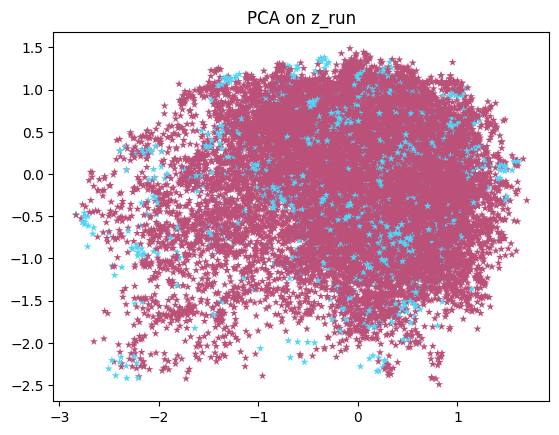

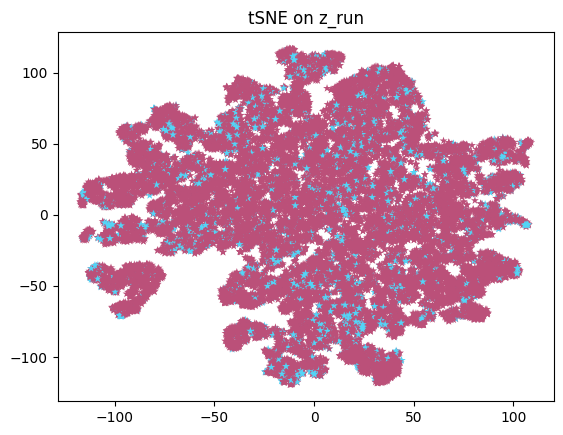

In [14]:
from utils import plot_clustering

plot_clustering(z_run, y_train, engine="matplotlib", download=False)

In [15]:
dataset = ECGDataset(X_test)
model.load("model_weights.pth")
z_run = model.reconstruct(dataset)

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/clearml/binding/frameworks/pytorch_bind.py:253: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [16]:
z_run = np.swapaxes(z_run, 0, 1)

In [17]:
print(z_run.shape)

(32352, 1000, 8)


(1000, 8)


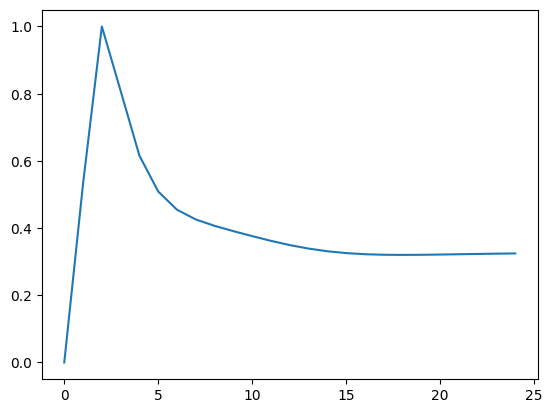

: 

In [18]:
import matplotlib.pyplot as plt

print(z_run[1].shape)

ecg = z_run[1].T[5] - np.min(z_run[1].T[5])
ecg = ecg / np.max(ecg)

plt.plot(ecg[0:25])

In [ ]:
from torchview import draw_graph

save_folder = "/home/kravchenko.artem/Projects/Diplomas/Classifiers/VAD/pictures"


model = vrae.VRAE(
    sequence_length=seq_len,
    number_of_features=input_dim,
    hidden_size=hidden_dim,
    hidden_layer_depth=1,
    block="GRU",
    latent_length=latent_dim,
    cuda=False,
    batch_size=batch_size,
)
draw_graph(
    model,
    input_size=(1, 5000, 8),
    expand_nested=True,
    roll=True,
    graph_dir="TB",
    filename=f"model_", 
    directory=str(save_folder),
    save_graph=True,
    device="cpu",
)

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.

